In [1]:
from pycaret.classification import * 

In [2]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


from tqdm import tqdm
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
from IPython.display import set_matplotlib_formats

sns.set(style='white', context='notebook', palette='deep')
line_color = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF','#40E0D0','#6495ED','#117A65','#2471A3','#CCCCFF','#8E44AD','#CD5C5C' ,'#F08080','#FA8072' ,'#E9967A' ,'#FFA07A']
plt.style.use('fivethirtyeight')
plt.style.use("seaborn-whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
print(plt.rcParams['font.family'])
%matplotlib inline

['Malgun Gothic']


# 데이터 불러오기

In [3]:
data=pd.read_csv('산불_전체기상데이터_정규화.csv',encoding='utf-8',index_col=0)

In [4]:
data['발생지역'].unique()

array(['KB', 'GW', 'KN', 'JN', 'GG', 'CN', 'JB', 'CB', 'SE'], dtype=object)

In [5]:
data.head()

,년,월,일,발생지역,지점,피해면적,평균기온(°C),평균 풍속(m/s),일강수량(mm),상대습도,실효습도,계절
0,2022,5,31,KB,992,5.30,1.071246,0.118464,-0.269151,39.4,35.771319,봄
1,2022,4,18,KB,992,0.03,0.299490,-0.138252,-0.269151,33.3,35.766492,봄
2,2022,10,19,KB,992,0.01,-0.472266,-0.394968,-0.269151,56.9,49.668174,기타
3,2022,12,20,KB,992,0.16,-1.645335,-0.822828,-0.269151,61.8,45.023499,가을
4,2022,4,20,KB,991,3.18,0.443551,0.631896,-0.269151,35.5,29.199069,봄


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10011 entries, 0 to 10010
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   년           10011 non-null  int64  
 1   월           10011 non-null  int64  
 2   일           10011 non-null  int64  
 3   발생지역        10011 non-null  object 
 4   지점          10011 non-null  int64  
 5   피해면적        10011 non-null  float64
 6   평균기온(°C)    10011 non-null  float64
 7   평균 풍속(m/s)  10011 non-null  float64
 8   일강수량(mm)    10011 non-null  float64
 9   상대습도        9368 non-null   float64
 10  실효습도        9345 non-null   float64
 11  계절          10011 non-null  object 
dtypes: float64(6), int64(4), object(2)
memory usage: 1016.7+ KB


In [7]:
data['년']=data['년'].astype(str)
data['월']=data['월'].astype(str)
data['일']=data['일'].astype(str)

In [8]:
data['날짜']=data['년']+data['월']+data['일']

In [9]:
data['날짜']=pd.to_datetime(data['날짜'],format='%Y%m%d')

In [10]:
data.head(1)

,년,월,일,발생지역,지점,피해면적,평균기온(°C),평균 풍속(m/s),일강수량(mm),상대습도,실효습도,계절,날짜
0,2022,5,31,KB,992,5.3,1.071246,0.118464,-0.269151,39.4,35.771319,봄,2022-05-31


In [11]:
data.columns

Index(['년', '월', '일', '발생지역', '지점', '피해면적', '평균기온(°C)', '평균 풍속(m/s)',
       '일강수량(mm)', '상대습도', '실효습도', '계절', '날짜'],
      dtype='object')

In [12]:
data.drop(['년','월','일','지점','계절'],axis=1,inplace=True)

In [13]:
data.head()

,발생지역,피해면적,평균기온(°C),평균 풍속(m/s),일강수량(mm),상대습도,실효습도,날짜
0,KB,5.30,1.071246,0.118464,-0.269151,39.4,35.771319,2022-05-31
1,KB,0.03,0.299490,-0.138252,-0.269151,33.3,35.766492,2022-04-18
2,KB,0.01,-0.472266,-0.394968,-0.269151,56.9,49.668174,2022-10-19
3,KB,0.16,-1.645335,-0.822828,-0.269151,61.8,45.023499,2022-12-20
4,KB,3.18,0.443551,0.631896,-0.269151,35.5,29.199069,2022-04-20


In [14]:
data['날짜']=pd.to_datetime(data['날짜'])
data[['계절']]=np.nan

In [15]:
for i in range(2001, 2023):
    data.loc[(f"{i}-02-01" <= data['날짜']) & (data['날짜'] <= f"{i}-05-15"), '계절']=data.loc[(f"{i}-02-01" <= data['날짜']) & (data['날짜'] <= f"{i}-05-15"), '계절'].fillna('봄')
    data.loc[(f"{i}-11-01" <= data['날짜']) & (data['날짜'] <= f"{i}-12-15"), '계절']=data.loc[(f"{i}-11-01" <= data['날짜']) & (data['날짜'] <= f"{i}-12-15"), '계절'].fillna('가을')
data[['계절']]=data[['계절']].fillna('그외')

In [16]:
import datetime
data['month'] = data['날짜'].dt.strftime('%m')

**발생지역별 월 평균을 구해서 결측값을 채우기위해 groupby 사용**

In [17]:
data.groupby(['발생지역','month']).mean()
data.groupby(['발생지역','month']).mean()[['상대습도']]

피해면적  평균기온(°C)  평균 풍속(m/s)  일강수량(mm)       상대습도       실효습도
발생지역 month                                                                 
CB   01      0.451250 -1.396323    0.304924 -0.280083  54.125000  46.540925
     02      1.475000 -1.018276    0.143988 -0.275974  52.681034  44.579490
     03      0.414277 -0.455692    0.389696 -0.266197  46.742000  41.375533
     04      1.625079  0.087467    0.309617 -0.262966  44.729379  39.778734
     05      0.538500  0.591024    0.053500 -0.263807  51.239623  42.789024
     06      0.580571  1.031992   -0.050226 -0.280083  52.802857  46.709153
     07      0.090000  1.310001   -0.320816 -0.280083  63.583333  54.657386
     08      0.018000  1.270793    0.003892 -0.280083  64.520000  52.354081
     09      0.247143  0.750567   -0.146865 -0.280083  64.542857  54.991598
     10      0.153333  0.011029   -0.621472 -0.280083  61.011111  53.725956
     11      0.278000 -0.779510    0.283502 -0.229133  57.835714  50.985871
     12      0.358333 -1.332569   -0.125390 -0.280083  56.820000  47.113939
CN   01      0.293636 -1.456381   -0.638961 -0.269448  60.870000  52.289713
     02      0.647375 -1.072394   -0.348198 -0.266133  52.897222  46.996696
     03      0.566750 -0.533266   -0.147148 -0.260828  53.108791  46.127555
     04      1.882284  0.020571    0.005466 -0.229834  50.586692  44.800696
     05      0.280000  0.594799   -0.218452 -0.267923  53.548148  46.641562
     06      0.276863  1.016600   -0.203613 -0.259047  62.234783  53.403778
     07      0.095714  1.361383    0.055260 -0.269448  61.200000  57.644209
     08      0.565455  1.509084    0.138567 -0.189080  69.200000  59.867919
     09      0.206538  0.779563   -0.245629 -0.269448  62.400000  54.445745
     10      0.060000  0.226272   -0.194297 -0.266848  67.971429  56.664291
     11      0.448333 -0.576071   -0.151207 -0.263554  60.344444  52.748126
     12      0.148214 -1.180214   -0.390199 -0.258397  65.074074  54.332177
GG   01      0.144375 -1.564776   -0.357281 -0.230354  55.512903  46.961223
     02      0.226429 -1.119138   -0.037001 -0.238075  50.982456  45.308149
     03      0.419098 -0.497430   -0.006019 -0.242787  51.457862  44.896858
     04      0.497707  0.020923    0.062167 -0.211078  49.437400  43.784688
     05      0.260071  0.519094   -0.016606 -0.214976  53.678226  46.320242
     06      0.244390  0.968496   -0.181329 -0.240432  54.810811  46.895884
     07      0.086154  1.339630   -0.081737 -0.234005  65.007692  55.714102
     08      0.186667  1.427660   -0.094529 -0.245401  65.572727  55.532623
     09      0.179655  0.810785   -0.225504 -0.214748  61.876923  54.781118
     10      0.132286  0.125221   -0.272612 -0.173440  65.209091  54.168946
     11      0.804455 -0.779758   -0.280718 -0.238433  59.067742  51.062329
     12      0.209674 -1.242099   -0.064451 -0.218830  54.952273  47.992267
GW   01      5.271818 -1.158772    0.552341 -0.263493  46.103226  38.761538
     02      3.516762 -1.072106    0.196057 -0.245027  47.843158  40.013465
     03     28.580145 -0.371210    0.213795 -0.260995  43.504145  39.384782
     04     17.183859  0.194934    0.228067 -0.248622  45.252518  40.072060
     05      5.807251  0.655872    0.087307 -0.233372  49.722751  43.852405
     06      0.221132  1.069386   -0.120970 -0.177114  56.613402  47.997972
     07      0.243750  1.379698   -0.243640 -0.263493  64.085714  53.830282
     08      0.816000  1.434030    0.105467 -0.192158  64.646154  54.738124
     09      0.065556  0.618804   -0.278307 -0.263493  65.425000  57.118474
     10      0.244490  0.202353   -0.451011 -0.257631  67.302326  56.297181
     11      0.845196 -0.814870    0.096473 -0.231106  53.603061  45.076981
     12      1.467558 -1.166108    0.395860 -0.259318  49.814634  42.466844
JB   01      0.142000 -1.536631   -0.817751 -0.278098  56.140000  46.259199
     02      0.579492 -0.985666   -0.203165 -0.274045  57.822034  50.102339
     03      0.510788 -0.513811   -0.135856 -0.213839  53.278344 

상대습도
발생지역 month           
CB   01     54.125000
     02     52.681034
     03     46.742000
     04     44.729379
     05     51.239623
     06     52.802857
     07     63.583333
     08     64.520000
     09     64.542857
     10     61.011111
     11     57.835714
     12     56.820000
CN   01     60.870000
     02     52.897222
     03     53.108791
     04     50.586692
     05     53.548148
     06     62.234783
     07     61.200000
     08     69.200000
     09     62.400000
     10     67.971429
     11     60.344444
     12     65.074074
GG   01     55.512903
     02     50.982456
     03     51.457862
     04     49.437400
     05     53.678226
     06     54.810811
     07     65.007692
     08     65.572727
     09     61.876923
     10     65.209091
     11     59.067742
     12     54.952273
GW   01     46.103226
     02     47.843158
     03     43.504145
     04     45.252518
     05     49.722751
     06     56.613402
     07     64.085714
     08     64.646154
     09     65.425000
     10     67.302326
     11     53.603061
     12     49.814634
JB   01     56.140000
     02     57.822034
     03     53.278344
     04     52.162434
     05     53.916949
     06     61.795652
     07     61.500000
     08     63.514286
     09     65.462500
     10     67.771429
     11     64.566667
     12     60.204762
JN   01     60.112500
     02     53.585276
     03     54.329221
     04     53.060484
     05     53.978431
     06     67.266667
     07     76.900000
     08     74.044444
     09     65.720000
     10     68.326667
     11     58.295349
     12     57.026154
KB   01     44.522222
     02     45.325316
     03     44.017536
     04     43.914930
     05     50.606417
     06     57.838525
     07     69.887500
     08     64.326316
     09     66.190000
     10     65.461702
     11     53.641765
     12     47.594815
KN   01     42.600000
     02     42.692063
     03     46.870886
     04     48.517241
     05     55.064423
     06     59.957143
     07     65.900000
     08     69.192857
     09     67.181250
     10     60.242623
     11     50.223313
     12     44.857965
SE   01     43.980000
     02     47.227586
     03     45.518812
     04     44.624000
     05     53.607692
     06     51.260870
     07     74.300000
     09     65.800000
     10     48.514286
     11     51.295455
     12     46.672727

In [18]:
cols=data.columns.drop(['피해면적', '평균기온(°C)', '평균 풍속(m/s)', '일강수량(mm)','계절','날짜','발생지역','month'])
cols

Index(['상대습도', '실효습도'], dtype='object')

In [19]:
cnt=0
for i in tqdm(range(len(cols))):
    for j in range(len(data)):
        if(np.isnan(data[[cols[i]]].loc[j].values[0])):  # 해당 컬럼의 값이 결측값이면 
            loc=data.loc[j]['발생지역']
            month=data.loc[j]['month']
            tmp=data.groupby(['발생지역','month']).mean()[[cols[i]]].loc[loc].loc[month].values[0]
            print(loc,month)
            print(tmp)
            cnt=cnt+1
            data[cols[i]].loc[j]=tmp

            print(data[[cols[i]]].loc[j])
print(cnt)

  0%|          | 0/2 [00:00<?, ?it/s]

KB 04
43.91492957746479
상대습도    43.91493
Name: 5, dtype: float64
GG 05
53.67822580645161
상대습도    53.678226
Name: 65, dtype: float64
KN 04
48.51724137931034
상대습도    48.517241
Name: 627, dtype: float64
KN 10
60.24262295081967
상대습도    60.242623
Name: 703, dtype: float64
KN 04
48.51724137931034
상대습도    48.517241
Name: 706, dtype: float64
KN 02
42.69206349206349
상대습도    42.692063
Name: 707, dtype: float64
JN 03
54.32922077922078
상대습도    54.329221
Name: 709, dtype: float64
KN 02
42.69206349206349
상대습도    42.692063
Name: 711, dtype: float64
KN 01
42.6
상대습도    42.6
Name: 716, dtype: float64
KN 04
48.51724137931035
상대습도    48.517241
Name: 755, dtype: float64
KN 05
55.06442307692308
상대습도    55.064423
Name: 777, dtype: float64
KN 04
48.51724137931035
상대습도    48.517241
Name: 786, dtype: float64
KN 10
60.24262295081967
상대습도    60.242623
Name: 787, dtype: float64
KN 05
55.06442307692308
상대습도    55.064423
Name: 917, dtype: float64
KN 12
44.85796460176991
상대습도    44.857965
Name: 922, dtype: float64
KN

JN 04
53.060483870967744
상대습도    53.060484
Name: 3821, dtype: float64
JN 03
54.329220779220776
상대습도    54.329221
Name: 3823, dtype: float64
JN 04
53.060483870967744
상대습도    53.060484
Name: 3827, dtype: float64
JN 03
54.32922077922078
상대습도    54.329221
Name: 3910, dtype: float64
JN 03
54.329220779220776
상대습도    54.329221
Name: 3911, dtype: float64
JN 04
53.060483870967744
상대습도    53.060484
Name: 3918, dtype: float64
JN 02
53.58527607361963
상대습도    53.585276
Name: 3926, dtype: float64
JN 11
58.2953488372093
상대습도    58.295349
Name: 3928, dtype: float64
JN 05
53.97843137254902
상대습도    53.978431
Name: 3929, dtype: float64
JN 04
53.060483870967744
상대습도    53.060484
Name: 3932, dtype: float64
JN 02
53.58527607361963
상대습도    53.585276
Name: 3938, dtype: float64
JN 03
54.329220779220776
상대습도    54.329221
Name: 3940, dtype: float64
JN 12
57.026153846153846
상대습도    57.026154
Name: 3942, dtype: float64
JN 10
68.32666666666667
상대습도    68.326667
Name: 3984, dtype: float64
JN 02
53.58527607361963
상대습

JN 04
53.060483870967744
상대습도    53.060484
Name: 5130, dtype: float64
JN 04
53.060483870967744
상대습도    53.060484
Name: 5133, dtype: float64
JN 03
54.329220779220776
상대습도    54.329221
Name: 5134, dtype: float64
GW 05
49.72275132275132
상대습도    49.722751
Name: 5319, dtype: float64
GW 06
56.61340206185567
상대습도    56.613402
Name: 5320, dtype: float64
GW 05
49.72275132275133
상대습도    49.722751
Name: 5322, dtype: float64
GW 05
49.72275132275132
상대습도    49.722751
Name: 5323, dtype: float64
GW 05
49.72275132275132
상대습도    49.722751
Name: 5324, dtype: float64
GW 03
43.5041450777202
상대습도    43.504145
Name: 5325, dtype: float64
GW 04
45.25251798561151
상대습도    45.252518
Name: 5326, dtype: float64
GW 03
43.5041450777202
상대습도    43.504145
Name: 5327, dtype: float64
GW 09
65.425
상대습도    65.425
Name: 5328, dtype: float64
GW 02
47.84315789473685
상대습도    47.843158
Name: 5329, dtype: float64
GG 03
51.45786163522012
상대습도    51.457862
Name: 5354, dtype: float64
GG 03
51.45786163522013
상대습도    51.457862
Name:

CN 04
50.586692015209124
상대습도    50.586692
Name: 6507, dtype: float64
CN 03
53.10879120879121
상대습도    53.108791
Name: 6577, dtype: float64
CN 06
62.234782608695646
상대습도    62.234783
Name: 6631, dtype: float64
CN 06
62.23478260869565
상대습도    62.234783
Name: 6632, dtype: float64
CN 03
53.10879120879121
상대습도    53.108791
Name: 6635, dtype: float64
CN 09
62.4
상대습도    62.4
Name: 6636, dtype: float64
CN 03
53.10879120879121
상대습도    53.108791
Name: 6641, dtype: float64
CB 03
46.742000000000004
상대습도    46.742
Name: 6731, dtype: float64
CB 04
44.72937853107345
상대습도    44.729379
Name: 6734, dtype: float64
CB 05
51.23962264150943
상대습도    51.239623
Name: 6740, dtype: float64
CB 03
46.742
상대습도    46.742
Name: 6748, dtype: float64
CB 04
44.72937853107344
상대습도    44.729379
Name: 6749, dtype: float64
CB 04
44.72937853107344
상대습도    44.729379
Name: 6804, dtype: float64
CB 04
44.72937853107344
상대습도    44.729379
Name: 6805, dtype: float64
CB 02
52.68103448275862
상대습도    52.681034
Name: 6806, dtype: float

GW 03
43.5041450777202
상대습도    43.504145
Name: 8535, dtype: float64
GW 04
45.25251798561151
상대습도    45.252518
Name: 8664, dtype: float64
GG 09
61.87692307692307
상대습도    61.876923
Name: 8707, dtype: float64
GG 03
51.45786163522012
상대습도    51.457862
Name: 8710, dtype: float64
GG 03
51.45786163522013
상대습도    51.457862
Name: 8720, dtype: float64
GG 06
54.810810810810814
상대습도    54.810811
Name: 8725, dtype: float64
GG 03
51.45786163522013
상대습도    51.457862
Name: 8727, dtype: float64
GG 04
49.437400000000004
상대습도    49.4374
Name: 8747, dtype: float64
GG 11
59.06774193548387
상대습도    59.067742
Name: 8748, dtype: float64
GG 12
54.95227272727273
상대습도    54.952273
Name: 8749, dtype: float64
GG 05
53.678225806451614
상대습도    53.678226
Name: 8750, dtype: float64
GG 04
49.4374
상대습도    49.4374
Name: 8751, dtype: float64
GG 05
53.678225806451614
상대습도    53.678226
Name: 8924, dtype: float64
GG 04
49.4374
상대습도    49.4374
Name: 8926, dtype: float64
GG 03
51.45786163522013
상대습도    51.457862
Name: 8927, dty

KB 03
38.91900073222749
실효습도    38.919001
Name: 1953, dtype: float64
KB 03
38.919000732227495
실효습도    38.919001
Name: 2133, dtype: float64
KB 05
44.05110983870967
실효습도    44.05111
Name: 2141, dtype: float64
KB 02
39.22552956962025
실효습도    39.22553
Name: 2144, dtype: float64
KB 02
39.22552956962025
실효습도    39.22553
Name: 2145, dtype: float64
KB 05
44.05110983870968
실효습도    44.05111
Name: 2152, dtype: float64
KB 05
44.05110983870967
실효습도    44.05111
Name: 2153, dtype: float64
KB 12
40.342436400000004
실효습도    40.342436
Name: 2155, dtype: float64
KB 01
38.24286387640449
실효습도    38.242864
Name: 2212, dtype: float64
KB 02
39.22552956962026
실효습도    39.22553
Name: 2245, dtype: float64
KB 02
39.22552956962025
실효습도    39.22553
Name: 2250, dtype: float64
KB 04
38.77849686760564
실효습도    38.778497
Name: 2262, dtype: float64
KB 12
40.3424364
실효습도    40.342436
Name: 2268, dtype: float64
KB 04
38.77849686760563
실효습도    38.778497
Name: 2347, dtype: float64
KB 03
38.91900073222749
실효습도    38.919001
Name

JN 05
47.55268982352941
실효습도    47.55269
Name: 4768, dtype: float64
JN 11
50.6697103255814
실효습도    50.66971
Name: 4808, dtype: float64
JN 11
50.6697103255814
실효습도    50.66971
Name: 4810, dtype: float64
JN 02
46.568112846625766
실효습도    46.568113
Name: 4811, dtype: float64
JN 09
58.3985649
실효습도    58.398565
Name: 4812, dtype: float64
JN 03
47.14560255194805
실효습도    47.145603
Name: 4813, dtype: float64
JN 03
47.14560255194805
실효습도    47.145603
Name: 4814, dtype: float64
JN 04
46.32476034146342
실효습도    46.32476
Name: 4816, dtype: float64
JB 05
47.02151989830509
실효습도    47.02152
Name: 4821, dtype: float64
JB 04
45.1508648342246
실효습도    45.150865
Name: 4822, dtype: float64
JB 04
45.15086483422459
실효습도    45.150865
Name: 4823, dtype: float64
JB 11
54.078088799999996
실효습도    54.078089
Name: 4824, dtype: float64
JB 03
46.86559115923567
실효습도    46.865591
Name: 4825, dtype: float64
JN 10
57.033260999999996
실효습도    57.033261
Name: 4830, dtype: float64
JN 03
47.14560255194805
실효습도    47.145603
Name

CN 03
46.127555439560446
실효습도    46.127555
Name: 6098, dtype: float64
CN 04
44.80069584732824
실효습도    44.800696
Name: 6099, dtype: float64
CN 04
44.80069584732824
실효습도    44.800696
Name: 6100, dtype: float64
CN 11
52.74812611111111
실효습도    52.748126
Name: 6101, dtype: float64
CN 04
44.80069584732824
실효습도    44.800696
Name: 6104, dtype: float64
CN 02
46.996696375
실효습도    46.996696
Name: 6108, dtype: float64
CN 03
46.12755543956044
실효습도    46.127555
Name: 6110, dtype: float64
CN 04
44.80069584732824
실효습도    44.800696
Name: 6113, dtype: float64
CN 05
46.641562111111114
실효습도    46.641562
Name: 6114, dtype: float64
CN 04
44.80069584732824
실효습도    44.800696
Name: 6116, dtype: float64
CN 02
46.996696375
실효습도    46.996696
Name: 6120, dtype: float64
CN 03
46.12755543956044
실효습도    46.127555
Name: 6121, dtype: float64
CN 03
46.12755543956044
실효습도    46.127555
Name: 6122, dtype: float64
CN 03
46.12755543956044
실효습도    46.127555
Name: 6126, dtype: float64
CN 08
59.867919375
실효습도    59.867919
Name:

GW 04
40.072059636690646
실효습도    40.07206
Name: 7602, dtype: float64
GW 04
40.072059636690646
실효습도    40.07206
Name: 7608, dtype: float64
GW 03
39.3847821761658
실효습도    39.384782
Name: 7610, dtype: float64
GW 12
42.46684426829268
실효습도    42.466844
Name: 7611, dtype: float64
GW 10
56.2971805116279
실효습도    56.297181
Name: 7612, dtype: float64
GW 04
40.072059636690646
실효습도    40.07206
Name: 7632, dtype: float64
GW 04
40.072059636690646
실효습도    40.07206
Name: 7633, dtype: float64
GW 05
43.852405069148936
실효습도    43.852405
Name: 7634, dtype: float64
GW 04
40.072059636690646
실효습도    40.07206
Name: 7635, dtype: float64
GW 05
43.852405069148936
실효습도    43.852405
Name: 7636, dtype: float64
GW 01
38.7615379
실효습도    38.761538
Name: 7644, dtype: float64
GW 11
45.076981010204086
실효습도    45.076981
Name: 7698, dtype: float64
GW 05
43.852405069148936
실효습도    43.852405
Name: 7726, dtype: float64
GW 04
40.072059636690646
실효습도    40.07206
Name: 7744, dtype: float64
GW 04
40.072059636690646
실효습도    40.072

GG 03
44.896858138364784
실효습도    44.896858
Name: 9115, dtype: float64
CN 04
44.80069584732824
실효습도    44.800696
Name: 9118, dtype: float64
CN 03
46.12755543956044
실효습도    46.127555
Name: 9119, dtype: float64
CN 03
46.12755543956044
실효습도    46.127555
Name: 9121, dtype: float64
CN 02
46.996696375
실효습도    46.996696
Name: 9122, dtype: float64
GG 11
51.06232854838709
실효습도    51.062329
Name: 9165, dtype: float64
GG 04
43.78468839
실효습도    43.784688
Name: 9174, dtype: float64
GG 02
45.30814942105263
실효습도    45.308149
Name: 9185, dtype: float64
GG 06
46.89588402739726
실효습도    46.895884
Name: 9276, dtype: float64
GG 03
44.89685813836478
실효습도    44.896858
Name: 9277, dtype: float64
GG 02
45.30814942105263
실효습도    45.308149
Name: 9283, dtype: float64
JB 04
45.1508648342246
실효습도    45.150865
Name: 9615, dtype: float64
GW 03
39.3847821761658
실효습도    39.384782
Name: 9727, dtype: float64
GW 04
40.072059636690646
실효습도    40.07206
Name: 9729, dtype: float64
GW 05
43.852405069148936
실효습도    43.852405
Nam

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10011 entries, 0 to 10010
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   발생지역        10011 non-null  object        
 1   피해면적        10011 non-null  float64       
 2   평균기온(°C)    10011 non-null  float64       
 3   평균 풍속(m/s)  10011 non-null  float64       
 4   일강수량(mm)    10011 non-null  float64       
 5   상대습도        10011 non-null  float64       
 6   실효습도        10011 non-null  float64       
 7   날짜          10011 non-null  datetime64[ns]
 8   계절          10011 non-null  object        
 9   month       10011 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 1.1+ MB


In [21]:
data['계절'].value_counts()

봄     6779
그외    2089
가을    1143
Name: 계절, dtype: int64

In [22]:
data.describe()

,피해면적,평균기온(°C),평균 풍속(m/s),일강수량(mm),상대습도,실효습도
count,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000
mean,4.318035,-0.314382,0.019387,-0.244542,50.824441,44.126488
std,171.710795,0.804896,0.863906,0.158189,12.883880,8.781532
min,0.000000,-2.651920,-1.673767,-0.280083,10.400000,18.425328
25%,0.030000,-0.898390,-0.547116,-0.269151,42.000000,38.134065
50%,0.100000,-0.331327,-0.201567,-0.265740,50.500000,44.109117
75%,0.400000,0.260873,0.325066,-0.263493,59.300000,49.918747
max,16301.980000,1.997354,11.249907,4.086121,98.100000,75.617412


In [23]:
data = pd.get_dummies(data = data, columns = ['계절'], prefix = '계절')

In [24]:
#data['계절'] = data['계절'].map({'봄': 2, '가을': 1, '그외': 0})

In [25]:
#data['계절'].value_counts()

In [26]:
data = data.rename(columns={ data.columns[9]: '가을', data.columns[10]: '여름겨울', data.columns[11]: '봄'})

In [27]:
data.head(2)

,발생지역,피해면적,평균기온(°C),평균 풍속(m/s),일강수량(mm),상대습도,실효습도,날짜,month,가을,여름겨울,봄
0,KB,5.30,1.071246,0.118464,-0.269151,39.4,35.771319,2022-05-31,05,0,1,0
1,KB,0.03,0.299490,-0.138252,-0.269151,33.3,35.766492,2022-04-18,04,0,0,1


In [28]:
data.drop(['발생지역','날짜','month'],axis=1,inplace=True)

In [29]:
heatmap_data = data[['피해면적', '평균기온(°C)', '평균 풍속(m/s)', '일강수량(mm)', '상대습도', '실효습도', '가을',
       '여름겨울', '봄']]

In [30]:
#heatmap_data = data[['피해면적','상대습도', '기온', '강수량', '풍속', '실효습도','계절']]

In [31]:
for i in range(len(data)):
    if data['피해면적'][i]<0.1 :
        data['피해면적'][i]=1
    elif (data['피해면적'][i]>=0.1) & (data['피해면적'][i]<0.5) :
        data['피해면적'][i]=2
    elif (data['피해면적'][i]>=0.5) & (data['피해면적'][i]<5) :
        data['피해면적'][i]=3
    else :
        data['피해면적'][i]=4

In [32]:
data['피해면적'].value_counts()

2.0    3790
1.0    3778
3.0    2159
4.0     284
Name: 피해면적, dtype: int64

<Figure size 2500x2000 with 0 Axes>

<AxesSubplot:>

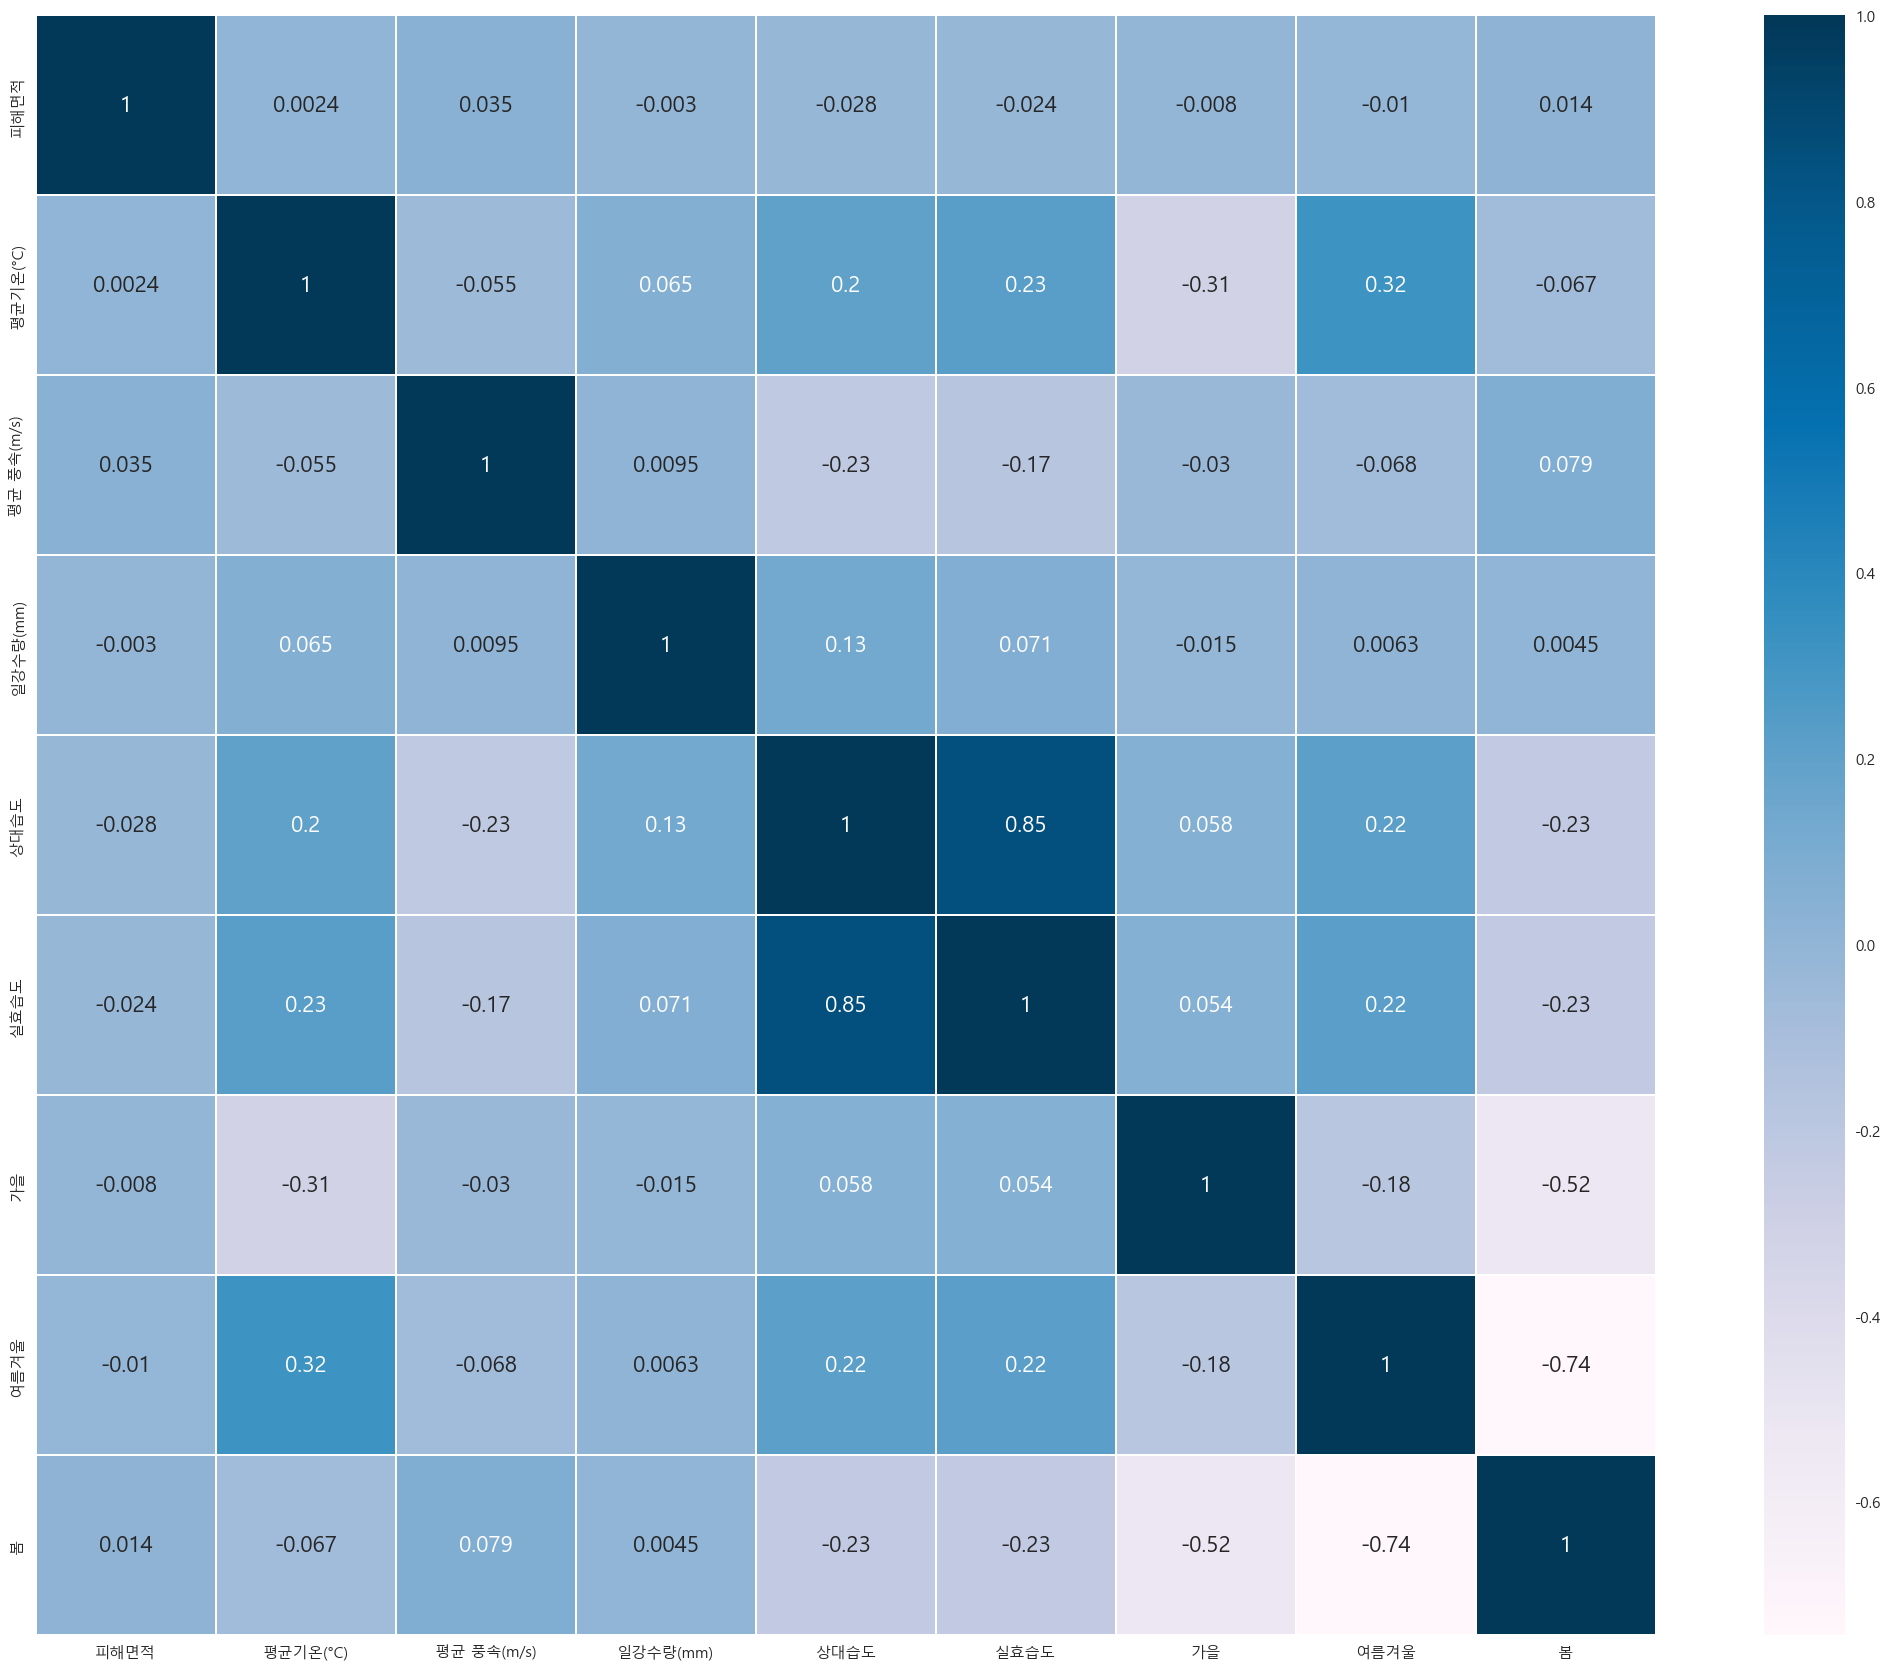

In [33]:
colormap = plt.cm.PuBu
plt.figure(figsize=(25, 20))
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

DATA split

In [34]:
#data.drop(['봄','여름겨울','가을'],axis=1,inplace=True)

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train=data

target = train['피해면적'][:len(train)]

print(train.shape,target.shape)

train.drop(['피해면적'],axis=1,inplace=True)

(10011, 9) (10011,)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2,stratify=target,random_state=42) 

print(X_train.shape, X_test.shape,  y_train.shape, y_test.shape )

(8008, 8) (2003, 8) (8008,) (2003,)


# RandomForest

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model1 = RandomForestClassifier(n_estimators=100,random_state=42)
model1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
prediction = model1.predict(X_test)
print("Accuracy is: ", accuracy_score(prediction, y_test))
acc_RF=accuracy_score(prediction, y_test)

Accuracy is:  0.4313529705441837


In [39]:
from sklearn.metrics import confusion_matrix

<AxesSubplot:>

Text(0.5, 7.222222222222195, 'Predicted Label')

Text(32.72222222222222, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix')

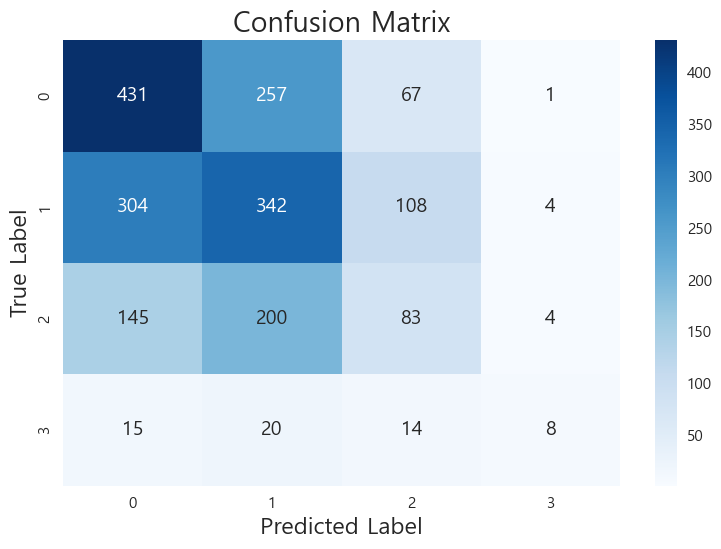

In [40]:
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [41]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

precision = precision_score(y_test, prediction, average=None)
recall = recall_score(y_test, prediction, average=None)

print("Precision:", precision)
print("Recall:", recall)

Precision: [0.48156425 0.41758242 0.30514706 0.47058824]
Recall: [0.57010582 0.45118734 0.19212963 0.14035088]


<BarContainer object of 8 artists>

Text(0.5, 0, 'CatBoost Feature Importance')

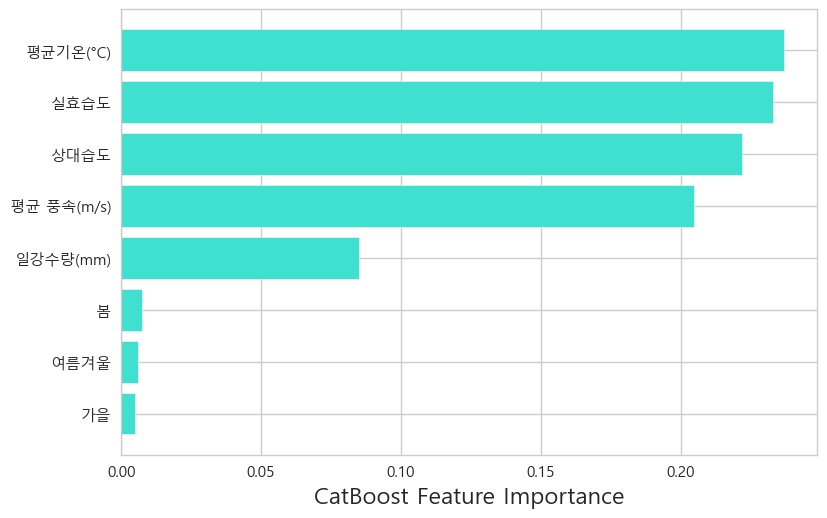

In [42]:
sorted_feature_importance = model1.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_feature_importance],
        model1.feature_importances_[sorted_feature_importance],
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

# CatBoost

In [43]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(n_estimators=100,random_state=42)
model.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 1.2500579	total: 146ms	remaining: 14.4s
1:	learn: 1.1865853	total: 150ms	remaining: 7.36s
2:	learn: 1.1561161	total: 156ms	remaining: 5.04s
3:	learn: 1.1392746	total: 160ms	remaining: 3.85s
4:	learn: 1.1246475	total: 165ms	remaining: 3.13s
5:	learn: 1.1180527	total: 169ms	remaining: 2.65s
6:	learn: 1.1146527	total: 174ms	remaining: 2.31s
7:	learn: 1.1086525	total: 178ms	remaining: 2.04s
8:	learn: 1.1045609	total: 181ms	remaining: 1.83s
9:	learn: 1.1004596	total: 184ms	remaining: 1.66s
10:	learn: 1.0925939	total: 188ms	remaining: 1.52s
11:	learn: 1.0874228	total: 192ms	remaining: 1.41s
12:	learn: 1.0847486	total: 195ms	remaining: 1.3s
13:	learn: 1.0827903	total: 198ms	remaining: 1.22s
14:	learn: 1.0793400	total: 202ms	remaining: 1.14s
15:	learn: 1.0771804	total: 206ms	remaining: 1.08s
16:	learn: 1.0744918	total: 209ms	remaining: 1.02s
17:	learn: 1.0718879	total: 212ms	remaining: 966ms
18:	learn: 1.0696572	total: 215ms	remaining: 916ms
19:	learn: 1.0670

In [44]:
prediction = model.predict(X_test)
print("Accuracy is: ", accuracy_score(prediction, y_test))
acc_RF=accuracy_score(prediction, y_test)

Accuracy is:  0.42286570144782826


<BarContainer object of 8 artists>

Text(0.5, 0, 'CatBoost Feature Importance')

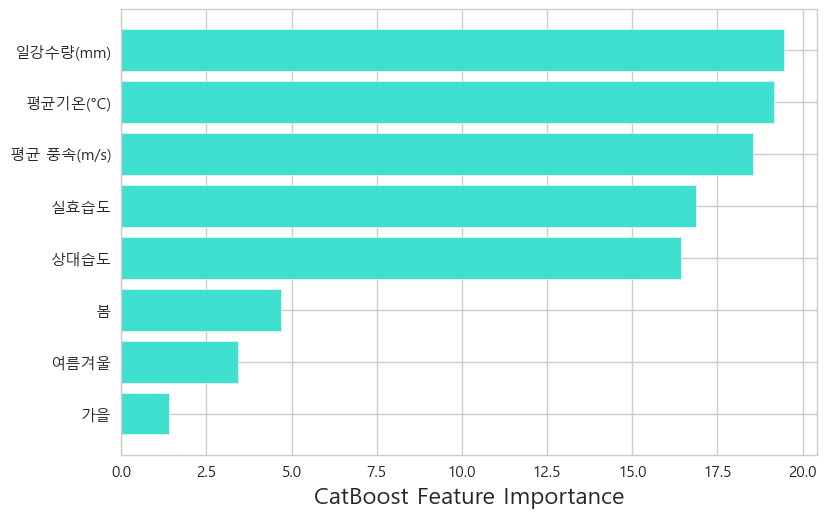

In [45]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_feature_importance],
        model.feature_importances_[sorted_feature_importance],
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

<AxesSubplot:>

Text(0.5, 7.222222222222195, 'Predicted Label')

Text(32.72222222222222, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix')

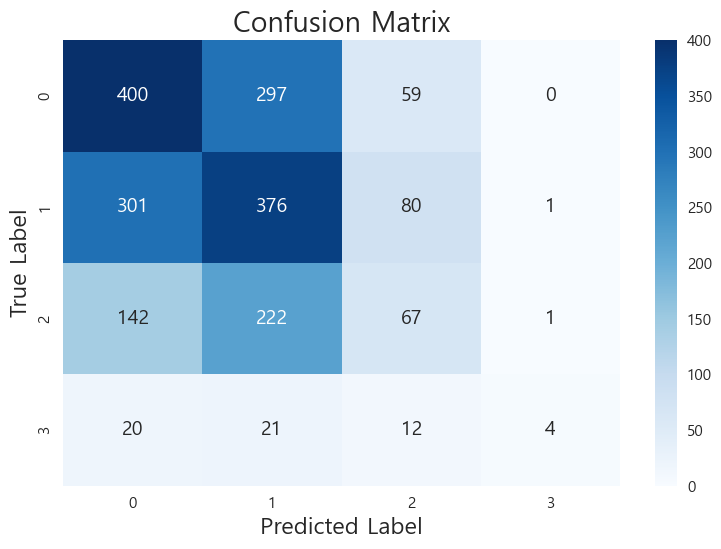

In [46]:
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [47]:
precision = precision_score(y_test, prediction, average=None)
recall = recall_score(y_test, prediction, average=None)

print("Precision:", precision)
print("Recall:", recall)

Precision: [0.46349942 0.41048035 0.30733945 0.66666667]
Recall: [0.52910053 0.49604222 0.15509259 0.07017544]


.

.